In [4]:
import os
import pandas as pd
import xgboost as xgb
import numpy as np
import statsmodels as sm
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.preprocessing import OneHotEncoder
import tweedie
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pygraphviz
#warnings.filterwarnings(action='ignore', category=UserWarning)
from xgboost import plot_tree

import optuna as op

In [2]:
class train_validate_n_test(object):

    def __init__(self) -> None:    
        dataset_filename = "xgboost_feat_train_ds_stn_130.csv"
        self.stn = dataset_filename.split("_stn_")[1].split(".")[0]
        self.train_set, self.val_set, self.test_set = self.train_val_test_split(dataset_filename)


    def onehotencode_cat_var(self,ds_df):
        ds_df = ds_df.astype({"block_id_"+self.stn:str,"ts_of_day_"+self.stn:str,"hr_of_day_"+self.stn:str,"day_of_wk_"+self.stn:str,"day_of_mn_"+self.stn:str,"wk_of_mon_"+self.stn:str })
        ds_df = pd.get_dummies(ds_df, prefix_sep="_",columns =["block_id_"+self.stn,"ts_of_day_"+self.stn,"hr_of_day_"+self.stn,"day_of_wk_"+self.stn,"day_of_mn_"+self.stn,"wk_of_mon_"+self.stn],
        drop_first=True)
        #ds_df = ds_df.drop('rem_blk_outf_'+self.stn,axis=1)

        # ratio of postive to negative classes
        num_pos_instances = np.array(ds_df['target_'+self.stn].value_counts('Class'))[0] # most frequent class
        num_neg_instances = np.array(ds_df['target_'+self.stn].value_counts('Class'))[-2] # second least frequent class
        self.scale_pos_weight = int(num_pos_instances / num_neg_instances)
        return ds_df


    def train_val_test_split(self,dataset_filename):
        ds_df = pd.read_csv(dataset_filename)
        tot_len = len(ds_df) #10050

        ds_df = self.onehotencode_cat_var(ds_df)

        # use 60% as training set
        train_idx_end = int(tot_len*0.6)
        train_Set = ds_df.loc[:train_idx_end]
        train_Set = train_Set.drop(['Unnamed: 0', 'dt_ts'],axis=1)

        # ensure that val set has 3 weeks for data for 3 walk-forward validation sets
        # 3*7*24*6 = 3024 time slots
        val_idx_end = train_idx_end+1+3024
        val_Set = ds_df.loc[train_idx_end+1:val_idx_end]
        val_Set = val_Set.drop(['Unnamed: 0', 'dt_ts'],axis=1)
        
        # Use remaining for test set
        test_Set = ds_df.loc[val_idx_end+1:]
        test_Set = test_Set.drop(['Unnamed: 0', 'dt_ts'],axis=1)        
        return train_Set, val_Set, test_Set    


    def walk_forward_val_n_train_set(self,part):
        # split validation set into 3 parts
        part_idx = int(len(self.val_set)/3)
        self.val_set1 = self.val_set.iloc[:part_idx]
        self.val_set2 = self.val_set.iloc[part_idx+1:part_idx*2]
        self.val_set3 = self.val_set.iloc[part_idx*2+1:]


        if (part==1):
            # provide first part of validation set
            train = self.train_set.drop("target_"+self.stn, axis=1)
            label_train = pd.DataFrame(self.train_set["target_"+self.stn])
            dtrain1 = xgb.DMatrix(train, label=label_train)
            val = self.val_set1.drop("target_"+self.stn, axis=1)
            label_val = pd.DataFrame(self.val_set1["target_"+self.stn])
            dval1 = xgb.DMatrix(val, label=label_val)
            # print('\nset1\n')
            # print('\n',train, label_train)
            # print('\n',val, label_val,'\n')     
            return dtrain1, dval1
        
        elif (part==2):
            # append validation part to train set and provide 2nd part of val. set
            self.train2 = pd.concat([self.train_set,self.val_set1], axis=0)
            new_train = self.train2.drop("target_"+self.stn, axis=1)
            label_train = pd.DataFrame(self.train2["target_"+self.stn])
            dtrain2 = xgb.DMatrix(new_train, label=label_train)
            val2 = self.val_set2.drop("target_"+self.stn, axis=1)
            label_val = pd.DataFrame(self.val_set2["target_"+self.stn])
            dval2 = xgb.DMatrix(val2, label=label_val)        
            return dtrain2,dval2
        
        else:
            # append 1st and 2nd validation part to train set and provide 3rd part of val. set
            self.train3 = pd.concat([self.train2,self.val_set2], axis=0)
            new_train = self.train3.drop("target_"+self.stn, axis=1)
            label_train = pd.DataFrame(self.train3["target_"+self.stn])
            dtrain3 = xgb.DMatrix(new_train, label=label_train)
            val3 = self.val_set3.drop("target_"+self.stn, axis=1)
            label_val = pd.DataFrame(self.val_set3["target_"+self.stn])
            dval3 = xgb.DMatrix(val3, label=label_val)    
            return dtrain3,dval3



    def xgb_train_validate(self,num_round,max_depth, eta, subsample, colsample_bytree, objective, e_s_r, eval_met,tvr):

        # Hyperparameters and algorithm parameters are described here

        params = {"max_depth": max_depth,
                "eta": eta,
                "objective": objective,
                "subsample" : subsample,
                "colsample_bytree":colsample_bytree,
                'eval_metric':eval_met, ## try using AUC as well.. 
                'tweedie_variance_power': tvr,
                'gamma': 0.05,
                'reg_alpha': 0, 
                'reg_lambda':1,
                'min_child_weight':1,
                'scale_pos_weight': self.scale_pos_weight # important for imbalanced dataset, num_neg_instces/num_pos_instces

                }

        dtrain1, dval1 = self.walk_forward_val_n_train_set(part=1)
        watchlist1  = [(dtrain1,'train1_tweedie_loss'), (dval1, 'val1_tweedie_loss')]
        evals_result1 = {}
        model1 = xgb.train(params=params, dtrain=dtrain1, num_boost_round=num_round, evals=watchlist1, evals_result=evals_result1,  early_stopping_rounds=e_s_r )
        #val1_error = evals_result1['val1_tweedie_loss']['tweedie-nloglik@'+str(tvr)]

        dtrain2, dval2 = self.walk_forward_val_n_train_set(part=2)
        watchlist2  = [(dtrain2,'train2_tweedie_loss'), (dval2, 'val2_tweedie_loss')]
        evals_result2 = {}
        model2 = xgb.train(params=params, dtrain=dtrain2, num_boost_round=num_round, evals=watchlist2, evals_result=evals_result2, early_stopping_rounds=e_s_r,xgb_model=model1 )
        #val2_error = evals_result2['val2_tweedie_loss']['tweedie-nloglik@'+str(tvr)]

        dtrain3, dval3 = self.walk_forward_val_n_train_set(part=3)
        watchlist3  = [(dtrain3,'train3_tweedie_loss'), (dval3, 'val3_tweedie_loss')]
        evals_result3 = {}
        self.model3 = xgb.train(params=params, dtrain=dtrain3, num_boost_round=num_round, evals=watchlist3, evals_result=evals_result3, early_stopping_rounds=e_s_r,xgb_model=model2 )
        #val3_error = evals_result3['val3_tweedie_loss']['tweedie-nloglik@'+str(tvr)]

        print('\n')
        # print(val1_error)
        # print(val2_error)
        # print(val3_error)

        # val_avg_error = np.mean(val1_error,val2_error,val3_error)

        return #val_avg_error
    
    def plot_target_distribution(self,):
        col_list = self.train3.columns
        self.train3.loc[:][col_list[-1]].hist()
        plt.title('Histogram of target distribution')
        plt.xlabel('demand value (class)')
        plt.ylabel('count')
        plt.show()
        return


    def display_tweedie_plot(self,):
        tvs = tweedie.tweedie(mu=1, p=1.1, phi=1.5).rvs(6000)
        sn.set(rc={'figure.figsize':(10,5)})
        # plt.figure(figsize=(25,10))
        sn.distplot(tvs)
        plt.title('Parametric tweedie distribution')
        plt.xlabel('demand value (class)')
        plt.show()
        return


    def evaluate_predictions(self,):
        testx = self.test_set.drop('target_'+self.stn,axis=1)
        label_test = pd.DataFrame(self.test_set['target_'+self.stn])
        dtest = xgb.DMatrix(testx,label=label_test)
        preds = self.model3.predict(dtest)
        preds = np.rint(preds)
        label_test = label_test['target_'+self.stn].to_numpy()
        print('preds', len(preds))
        print('label_test', len(label_test))
    
        plt.plot(preds,'*')
        plt.ylabel('Demand value (prediction)')
        plt.xlabel('Time')     
        plt.show()
        plt.plot(label_test,'*')
        plt.ylabel('Demand value (Ground-truth)')
        plt.xlabel('Time')     
        plt.show()
        # plt.plot(label_test[40:60],'*')
        # plt.title('zoomed true label test')
        # plt.ylabel('Demand value')
        # plt.xlabel('Time')     
        # plt.show()
        # plt.plot(preds[40:60],'*')
        # plt.title('zoomed pred label')
        # plt.ylabel('Demand value')
        # plt.xlabel('Time')     
        # plt.show()


        #"use confusion matrix, ROC, F1 scores to evaluate"
        cm = confusion_matrix(label_test,preds)
        max_classes = max(len(np.unique(label_test)),len(np.unique(preds)))
        df_cm = pd.DataFrame(cm, index = [i for i in range(max_classes)],
                        columns = [i for i in range(max_classes)])
        plt.figure(figsize = (10,7))      
        s = sn.heatmap(df_cm, annot=True, )
        s.set(xlabel='Predicted-Label', ylabel='True-Label')

        return testx,label_test, preds


    def identify_tweedie_variance_param():
        #TODO:#"fit on data"
        # follow this tutorial https://notebook.community/thequackdaddy/tweedie/example/tweedie_demo
        # GLM.estimate_tweedie_power()
        # #Training model
        # tweedie_model = sm.GLM(y_train, X_train, exposure = df_train.exposure, family=sm.families.Tweedie(link=None,var_power=1.5,eql=True))
        # tweedie_result = tweedie_model.fit()
        # #Using the initial model output to decide the optimum index parameter "p"
        # GLM.estimate_tweedie_power(training_result, method='brentq', low=1.01, high=5.0)
        # tweedie_model.estimate_tweedie_power(tweedie_result.mu, method='brentq', low=1.01, high=5.0)
        return


    def make_predictions(self,):
        #TODO:#for new predictions after tuning model

        return
    

    def visualize_tree(self,):
        #TODO:#"draw out a few trees to interpret results"        
        #xgb.plot_tree(self.train3)
        plot_tree(self.model3)

        return

    def optuna_hp_opt(self,):


        return




[11:52:46] WARNING: ..\src\learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train1_tweedie_loss-tweedie-nloglik@1.1:0.86090	val1_tweedie_loss-tweedie-nloglik@1.1:0.99806
[1]	train1_tweedie_loss-tweedie-nloglik@1.1:0.76308	val1_tweedie_loss-tweedie-nloglik@1.1:0.90534
[2]	train1_tweedie_loss-tweedie-nloglik@1.1:0.69193	val1_tweedie_loss-tweedie-nloglik@1.1:0.83909
[3]	train1_tweedie_loss-tweedie-nloglik@1.1:0.64052	val1_tweedie_loss-tweedie-nloglik@1.1:0.79259
[4]	train1_tweedie_loss-tweedie-nloglik@1.1:0.60289	val1_tweedie_loss-tweedie-nloglik@1.1:0.75862
[5]	train1_tweedie_loss-tweedie-nloglik@1.1:0.57529	val1_tweedie_loss-tweedie-nloglik@1.1:0.73556
[6]	train1_tweedie_loss-tweedie-nloglik@1.1:0

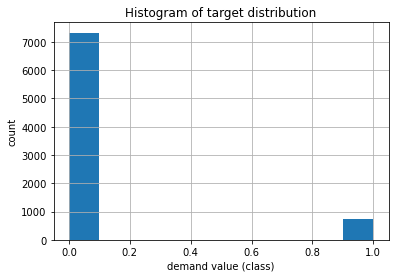

C:\Users\josepeeterson.er\AppData\Local\Temp\ipykernel_24568\3357300433.py:150: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(tvs)


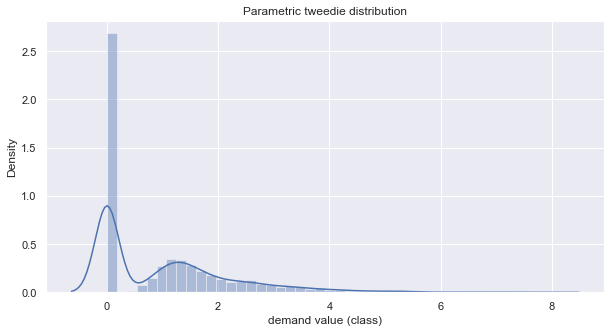

preds 994
label_test 994


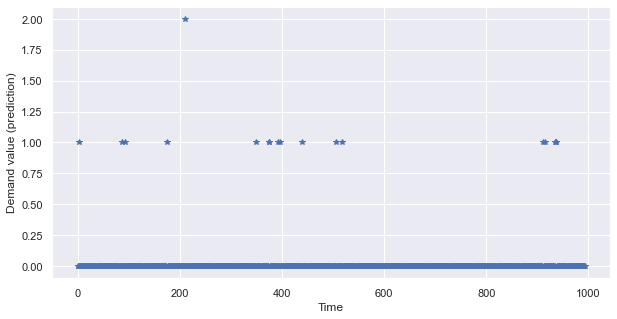

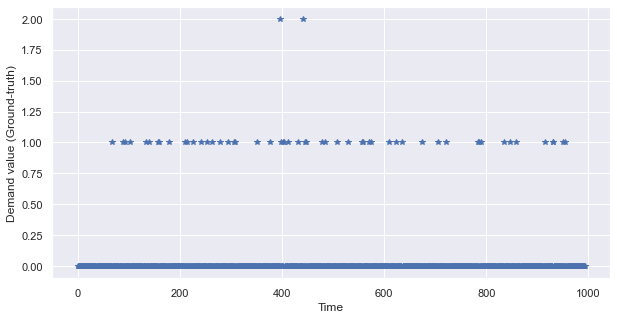

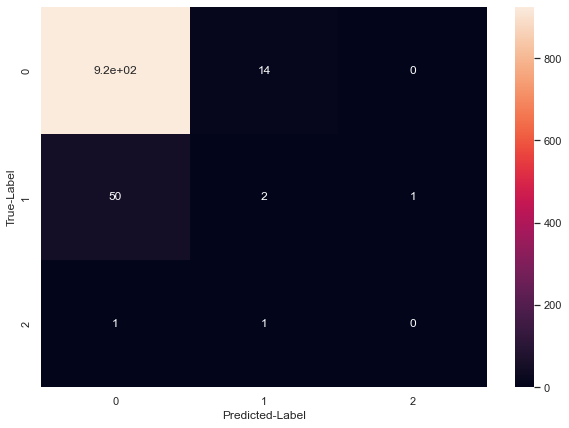

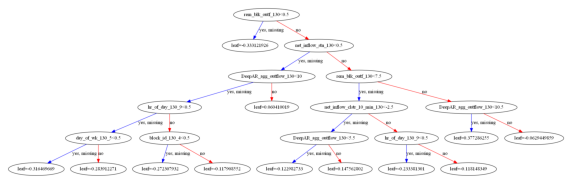

In [3]:
if __name__ == "__main__":
    os.chdir("c:\Work\WORK_PACKAGE\Demand_forecasting\BLUESG_Demand_data\Data-preprocessing_data_generation")
    t_v_t = train_validate_n_test()
    tweedie_variance_power = 1.1 #t_v.identify_tweedie_variance_param()
    
    ######  SET Hyperparameter's range for tuning ######
    early_stopping_rounds = 100
    eval_metric = 'tweedie-nloglik@'+str(tweedie_variance_power)
    num_round= 1000
    max_depth= 5
    eta=0.3
    subsample=1.0
    colsample_bytree=1.0
    objective= 'reg:tweedie'

    ######  SET Hyperparameter's range for tuning ######

    e_s_r = early_stopping_rounds
    eval_met = eval_metric
    tvr = tweedie_variance_power
    val_avg_error = t_v_t.xgb_train_validate(num_round,max_depth, eta, subsample, colsample_bytree, objective, e_s_r,eval_met,tvr)

    t_v_t.plot_target_distribution() # compare the graphs from this and below function to choose tweedie_variance_power 
    t_v_t.display_tweedie_plot()

    testx,label_test, preds = t_v_t.evaluate_predictions()

    t_v_t.visualize_tree()
    # print('\n',"tweedie_variance_power ",tweedie_variance_power,'\n')
